## Univariate LSTM-RNN Sumatera Selatan Percobaan 1

### 1. Deklarasi Pustaka

In [1]:
# pustaka untuk manipulasi data
import pandas as pd
from pandas import concat
from pandas import DataFrame
from pandas import read_csv
from pandas import read_excel
import numpy as np
from numpy import concatenate
from numpy import array

# pustaka untuk waktu komputasi
import time
from datetime import datetime

# Pustaka untuk visualisasi data
import seaborn as sns
from matplotlib import pyplot
from matplotlib import pyplot as plt

# Pustaka untuk visualisasi acf dan pacf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
        
# Pustaka untuk membuat data latih dan data uji.
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Pustaka untuk membuat model prediksi LSTM-RNN
import itertools
import tensorflow as tf
from keras.models import Sequential
from keras.layers import RNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD

# Early stoping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Pustaka untuk  evaluasi model prediksi
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### 2. Akuisisi Data

In [2]:
# set waktu komputasi
start = time.time()

In [3]:
# fix random seed for reproducibility
np.random.seed(1234)

In [4]:
# membaca dataset via csv file
dataset = pd.read_csv("dataset/modis_sumsel_bulanan.csv", parse_dates=['acq_date'], engine="python")

In [5]:
# # set index tanggal
# dataset = dataset.set_index("Date");

In [6]:
# menampilkan metadata dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   acq_date  240 non-null    datetime64[ns]
 1   hotspot   240 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.9 KB


In [7]:
# menampilkan dataset
dataset

,acq_date,hotspot
0,2001-01-31,3
1,2001-02-28,5
2,2001-03-31,10
3,2001-04-30,20
4,2001-05-31,39
...,...,...
235,2020-08-31,65
236,2020-09-30,29
237,2020-10-31,40
238,2020-11-30,30


### 3. Eksplorasi Data Analisis

- visualisasi data

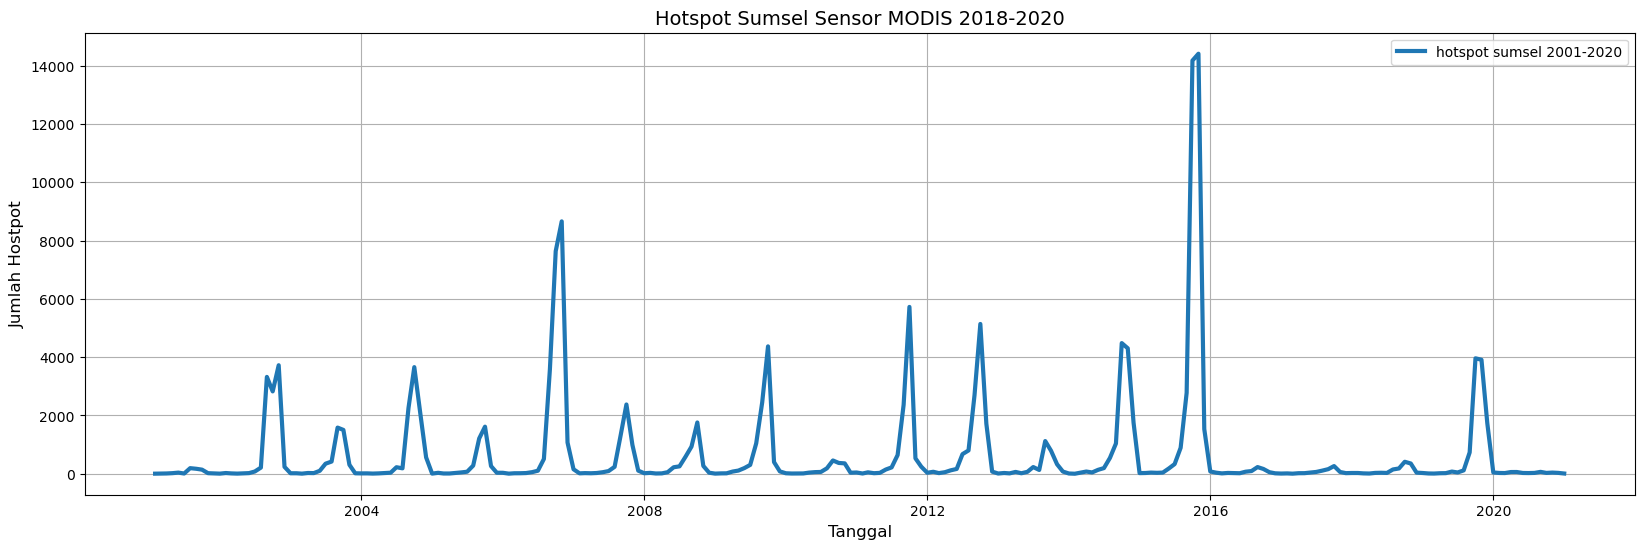

In [8]:
# membuat frame
fig, ax = plt.subplots(figsize = (20,6))

# membuat time series plot
ax.plot(dataset["acq_date"], dataset["hotspot"], color="tab:blue", label="hotspot sumsel 2001-2020", linewidth=3)

# membuat label-label
ax.set_title("Hotspot Sumsel Sensor MODIS 2018-2020", fontsize=14)
ax.set_xlabel("Tanggal", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc='best')
ax.grid(True)

# menampilkan plot
plt.show()

- Analisa ACF dan PACF

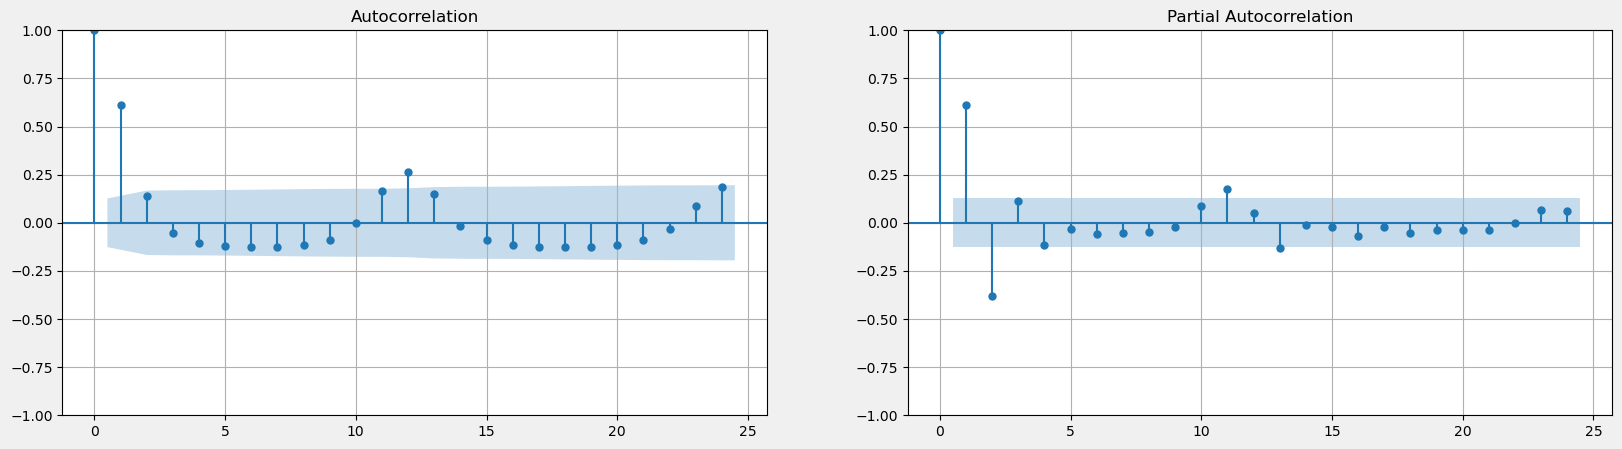

In [9]:
# kode autocorrelation
# membuat frame
fig, ax= plt.subplots(nrows=1, ncols=2, facecolor="#F0F0F0", figsize = (20,5))

# plot acf
plot_acf(dataset["hotspot"], lags=24, ax=ax[0])
ax[0].grid(True)

# plot pacf
plot_pacf(dataset["hotspot"],lags=24, ax=ax[1], method="yw")
ax[1].grid(True)

# menampilkan plot acf dan pacf
plt.show()

### 4. Praproses Data

- feature selection

In [10]:
# set a feature selection
df_sumsel = dataset.filter(["hotspot"])

In [11]:
# convert dataframe to series
df_sumsel = df_sumsel.values

In [12]:
# show a dataset
np.round(df_sumsel[:5],7)

array([[ 3],
       [ 5],
       [10],
       [20],
       [39]], dtype=int64)

In [13]:
# view a dimension dataset
df_sumsel.shape

(240, 1)

- normalization data

In [14]:
# normalize data with max-min algorithm
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(np.array(df_sumsel).reshape(-1,1))

In [15]:
# show a dataset after normalize
np.round(scaled_data[:5],7)

array([[-0.9997225],
       [-0.999445 ],
       [-0.9987513],
       [-0.9973639],
       [-0.9947277]])

In [16]:
# view a dimension dataset after normalize
scaled_data.shape

(240, 1)

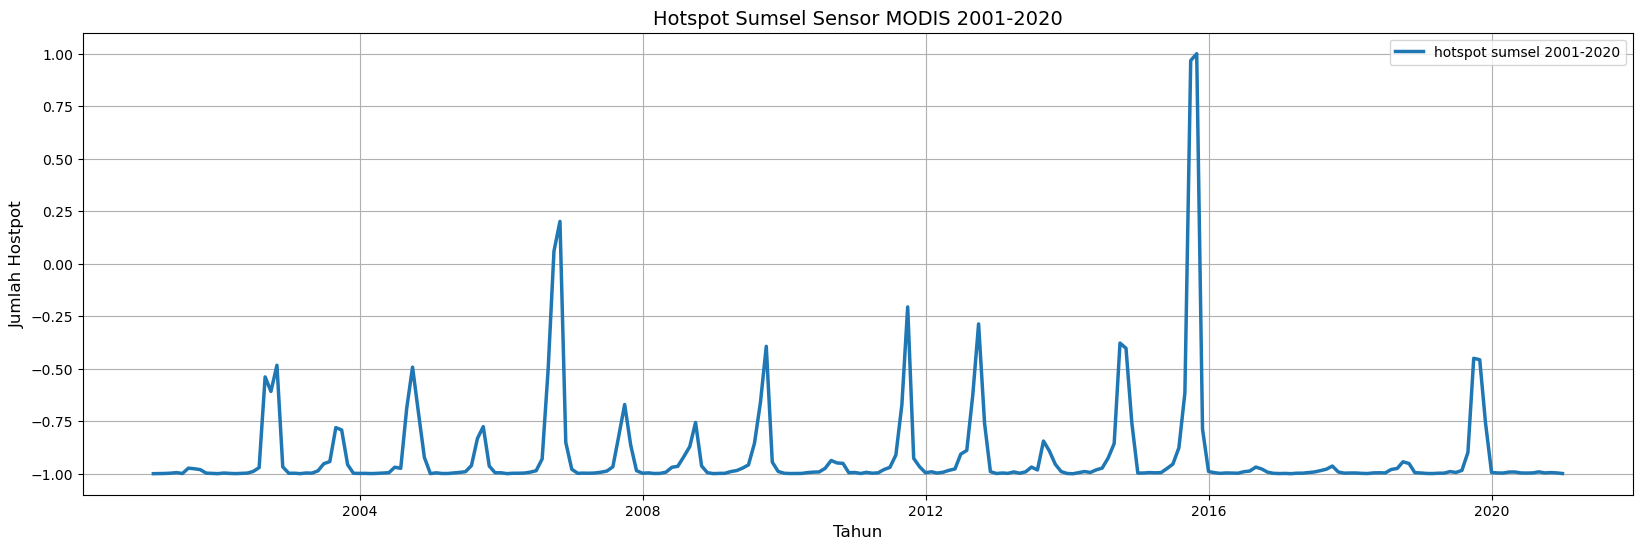

In [17]:
# make a frame
fig, ax = plt.subplots(figsize = (20,6))

# make a time series plot
ax.plot(dataset["acq_date"], scaled_data, color="tab:blue", label="hotspot sumsel 2001-2020", linewidth=2.5)

# make a labels
ax.set_title("Hotspot Sumsel Sensor MODIS 2001-2020", fontsize=14)
ax.set_xlabel("Tahun", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc='best')
ax.grid(True)

# show plot time series
plt.show()

- set data train and data test

In [18]:
# set data train
train_size = int(len(df_sumsel) * 0.8)

In [19]:
# set loc data train
train_data = scaled_data[0:train_size,:]

In [20]:
# show data train
np.round(train_data[:5],7)

array([[-0.9997225],
       [-0.999445 ],
       [-0.9987513],
       [-0.9973639],
       [-0.9947277]])

In [21]:
# view dimension of data train
train_data.shape

(192, 1)

In [22]:
# set data test
test_size = len(df_sumsel) - train_size

In [23]:
# set loc data train
test_data = scaled_data[train_size:len(df_sumsel),:]

In [24]:
# show data train
np.round(test_data[:5],7)

array([[-0.9984738],
       [-0.9997225],
       [-0.9975026],
       [-0.9973639],
       [-0.9944502]])

In [25]:
# view dimension of data train
test_data.shape

(48, 1)

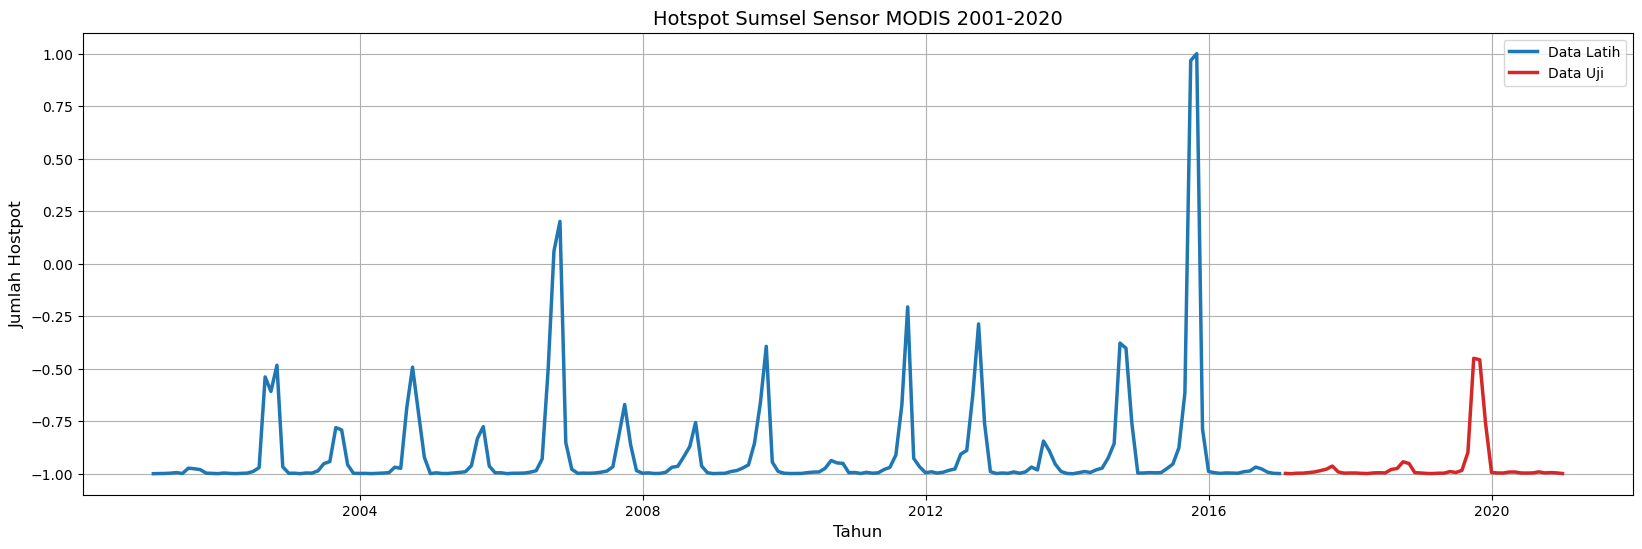

In [26]:
# make a frame
fig, ax = plt.subplots(figsize = (20,6))

# make a time series plot
ax.plot(dataset.iloc[0:train_size,0], train_data, color="tab:blue", label="Data Latih", linewidth=2.5)
ax.plot(dataset.iloc[train_size:len(scaled_data),0], test_data, color="tab:red", label="Data Uji", linewidth=2.5)

# make are labels
ax.set_title("Hotspot Sumsel Sensor MODIS 2001-2020", fontsize=14)
ax.set_xlabel("Tahun", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc="best")
ax.grid(True)

# show plot time series
plt.show()

### 5. Supervised Learning

In [27]:
# function for supervised learning
def create_dataset(dataset, look_back):
    
    # declare variable X and Y
    dataX = []
    dataY = []
    
    # for loop for create supervised learning
    for i in range(look_back, len(dataset)):
        
        # insert value X and Y 
        dataX.append(dataset[i-look_back:i, 0])
        dataY.append(dataset[i, 0])
        
    # return value X and Y
    return np.array(dataX), np.array(dataY)

- process supervised learning, with look back t-1 into X=t and Y=t+1

In [28]:
# set look back -1
look_back = 1

In [29]:
# set supervised learning for data train
x_train, y_train = create_dataset(train_data, look_back)

In [30]:
# view a dimension dataset after supervised learning
print(x_train.shape, y_train.shape)

(191, 1) (191,)


In [31]:
# set supervised learning for data test
x_test, y_test = create_dataset(test_data, look_back)

In [32]:
# view a dimension dataset after supervised learning
print(x_test.shape, y_test.shape)

(47, 1) (47,)


- Check data train, for result supervised learning

In [33]:
temp_trainX = pd.DataFrame(x_train, columns=['y train'])
temp_trainY = pd.DataFrame(y_train, columns=['x train'])

In [34]:
hasil_train = pd.concat([temp_trainX, temp_trainY], axis=1)
hasil_train.head()

,y train,x train
0,-0.999723,-0.999445
1,-0.999445,-0.998751
2,-0.998751,-0.997364
3,-0.997364,-0.994728
4,-0.994728,-0.999029


In [35]:
hasil_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   y train  191 non-null    float64
 1   x train  191 non-null    float64
dtypes: float64(2)
memory usage: 3.1 KB


- Check data test, for result supervised learning

In [36]:
temp_testX = pd.DataFrame(x_test, columns=['y test'])
temp_testY = pd.DataFrame(y_test, columns=['x test'])

In [37]:
hasil_test = pd.concat([temp_testX, temp_testY], axis=1)
hasil_test.head()

,y test,x test
0,-0.998474,-0.999723
1,-0.999723,-0.997503
2,-0.997503,-0.997364
3,-0.997364,-0.994450
4,-0.994450,-0.991537


In [38]:
hasil_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y test  47 non-null     float64
 1   x test  47 non-null     float64
dtypes: float64(2)
memory usage: 880.0 bytes


- reshape input to be [samples, time steps, features]

In [39]:
# reshape data train
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [40]:
print(x_train.shape, y_train.shape)

(191, 1, 1) (191,)


In [41]:
# reshape data train
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [42]:
print(x_test.shape, y_test.shape)

(47, 1, 1) (47,)


### 6. Modeling LSTM-RNN

In [43]:
# # Design network
# model = Sequential()

# # First LSTM layer with Dropout regularisation
# model.add(
#     LSTM(
#         units=10,
#         activation='selu',
#         input_shape=(trainX.shape[1], 1)
#     )
# )
# model.add(Dropout(0.2))

# # The output layer
# model.add(Dense(1))

# # Compiling model the LSTM-RNN
# # lr=0.0075, decay=0.00001
# model.compile(
#     optimizer='sgd',
#     loss='mae',
#     metrics=[
#         tf.keras.metrics.MeanAbsoluteError(),
#         tf.keras.metrics.MeanSquaredError(),
#         tf.keras.metrics.RootMeanSquaredError()
#     ]
# )

In [44]:
# # fit network
# history = model.fit(trainX, trainY, epochs=2000, batch_size=8,
#                     validation_data=(testX, testY),
#                     verbose=1, shuffle=False)

In [45]:
# model.summary()

In [46]:
# # membuat frame
# fig, ax = plt.subplots(figsize = (20,5))

# # membuat time series plot
# ax.plot(history.history['loss'], color="tab:blue", label="train", linewidth=1.5)
# ax.plot(history.history['val_loss'], color="tab:orange", label="test", linewidth=1.5)

# # membuat label-label
# ax.set_title("Grafik Loss Function", fontsize=14)
# ax.legend(loc='upper right')
# ax.grid(True)

# # menampilkan plot
# plt.show()

In [47]:
# # make predictions
# predictions = model.predict(testX, verbose=0)
# print(predictions[:, 0])

### 7. Evaluasi Model LSTM-RNN

In [48]:
# scores = model.evaluate(trainX, trainY)
# scores

In [49]:
# scores = model.evaluate(testX, testY)
# scores

- MAE (Mean Absolute Error)

In [50]:
# mae = mean_absolute_error(testY, predictions)
# print('Test MAE : %.4f' % mae)

- MSE (Mean Squared Error)

In [51]:
# mse = mean_squared_error(testY, predictions)
# print('Test MSE: %.4f' % mse)

- RMSE (Root Mean Squared Error)

In [52]:
# # calculate RMSE
# rmse = sqrt(mse)
# print('Test RMSE: %.4f' % rmse)

- Corelation pearson

In [53]:
# hasil = np.stack((testY.reshape(-1), predictions.reshape(-1)), axis=1)
# hasil = pd.DataFrame(hasil, columns = ['data_aktual','prediksi'])

In [54]:
# hasil.head()

In [55]:
# import scipy.stats as sc
# r, p = sc.pearsonr(hasil["data_aktual"], hasil["prediksi"])
# print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r)+ "dengan signifikansi" +" {:.4f} ".format(p))

- Complexity time

In [56]:
# # Set akhir waktu komputasi 
# end = time.time()

In [57]:
# # Proses menghitung waktu komputasi
# hours, rem = divmod(end-start, 3600)
# minutes, seconds = divmod(rem, 60)

In [58]:
# # Hasil waktu komputasi
# print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

### 8. Visualisasi Data

In [59]:
# # generate urutan data sesuai panjang datanya
# x = pd.date_range(start="2017-01-01", periods=len(testY), freq='MS')

# # membuat frame
# fig, ax = plt.subplots(figsize = (10,5))

# # membuat time series plot
# ax.plot(x, testY, color="tab:blue", label="data aktual", linewidth=2.5)
# ax.plot(x, predictions, color="tab:red", label="hasil prediksi", linewidth=2.5)

# # membuat label-label
# # ax.set_title("Hotspot Sumsel Sensor MODIS 2018-2020", fontsize=14)
# ax.set_xlabel("Tanggal", fontsize=12)
# ax.set_ylabel("Jumlah Hostpot", fontsize=12)
# ax.legend(loc='upper right')
# ax.grid(True)

# # menampilkan plot
# plt.show()